In [70]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from collections import defaultdict
from importlib import reload
from pathlib import Path

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import torch
import torchvision
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi

plt.rcParams["font.family"] = "serif"
fig_dir = Path("../figures")

import sys

sys.path.append("../src")
from torchvision import transforms

import utils
import valuation

In [4]:
datasets = [
    v["python_class"]
    for k, v in medmnist.INFO.items()
    if not k.endswith("3d") and not k.startswith("organ")
]

imgs = {
    d: np.load(Path("../../data/medmnist") / f"{d.lower()}_224.npz")["test_images"][0]
    for d in datasets
}

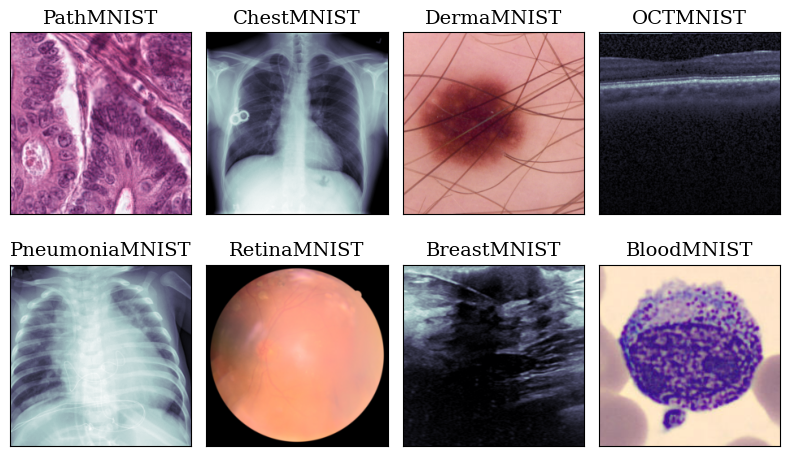

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=len(imgs) // 2, figsize=(8, 5))
for ax, (k, v) in zip(axes.flatten(), imgs.items()):
    ax.set_title(k, fontsize=14)
    if v.shape[0] == 1 or v.ndim == 2:
        cmap = "bone"
    else:
        cmap = None
    ax.imshow(v, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
# plt.savefig(fig_dir / "medmnist-images.eps")
plt.show()

In [6]:
med_datasets = sorted(Path("../../data/medmnist").glob("*_224.npz"))
med_datasets = {p.stem: p for p in med_datasets}
med_datasets

{'bloodmnist_224': PosixPath('../../data/medmnist/bloodmnist_224.npz'),
 'breastmnist_224': PosixPath('../../data/medmnist/breastmnist_224.npz'),
 'chestmnist_224': PosixPath('../../data/medmnist/chestmnist_224.npz'),
 'dermamnist_224': PosixPath('../../data/medmnist/dermamnist_224.npz'),
 'octmnist_224': PosixPath('../../data/medmnist/octmnist_224.npz'),
 'organamnist_224': PosixPath('../../data/medmnist/organamnist_224.npz'),
 'pathmnist_224': PosixPath('../../data/medmnist/pathmnist_224.npz'),
 'pneumoniamnist_224': PosixPath('../../data/medmnist/pneumoniamnist_224.npz'),
 'retinamnist_224': PosixPath('../../data/medmnist/retinamnist_224.npz'),
 'tissuemnist_224': PosixPath('../../data/medmnist/tissuemnist_224.npz')}

#### Skip this if using precomputed embeddings

In [7]:
saved_embedding_path = Path("../embeddings")
compute_embedding = False

if compute_embedding:
    assert torch.cuda.is_available()
    model, preprocess = clip.load("ViT-B/16", device="cuda")

    model.eval()
    make_loader = lambda ds, batch_size=16: torch.utils.data.DataLoader(
        ds,
        batch_size=batch_size,
    )
    for k, v in med_datasets.items():
        # if k in ('bloodmnist_224', 'breastmnist_224', 'chestmnist_224', 'dermamnist_224', 'ocamnist_224'):
        # continue
        with np.load(v) as data_array:
            images = data_array["train_images"]
            labels = data_array["train_labels"]

        emb = []
        # img = []
        lab = []
        for j, img in tqdm(enumerate(images), total=len(images)):
            if img.ndim == 2:
                img = img[:, :, None].repeat(3, axis=-1)
            e = model.encode_image(preprocess(img)[None].cuda()).detach().cpu()
            emb.append(e)
            if k != "chestmnist_224":
                l = labels.flatten()[j]
                lab.append(int(l))
            else:
                lab.append(torch.tensor(labels[j]))

        x_emb = torch.cat(emb)
        if k != "chestmnist_224":
            x_lab = torch.tensor(lab)
        else:
            x_lab = torch.cat(lab)

        save_name = f"clip_embedding_medmnist_{k}.pt"

        torch.save(
            {
                "embeddings": x_emb,
                "labels": x_lab,
            },
            saved_embedding_path / save_name,
        )
        print(k, "done")

In [12]:
datasets = {
    "Retina": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_retinamnist_224.pt"
    ),
    "Organ": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_organamnist_224.pt"
    ),
    "Breast": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_breastmnist_224.pt"
    ),
    "Pneumonia": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pneumoniamnist_224.pt"
    ),
    "Chest": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_chestmnist_224.pt"
    ),
    "OCT": torch.load(saved_embedding_path / "clip_embedding_medmnist_octmnist_224.pt"),
    "Tissue": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224.pt"
    ),
    "Path": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pathmnist_224.pt"
    ),
    "Derma": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_dermamnist_224.pt"
    ),
    "Blood": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224.pt"
    ),
}

# outliers are random selection of from all MedMNIST datasets
outlier_tensor = []
for j in range(500):
    for ds in datasets.values():
        outlier_tensor.append(ds["embeddings"][j])

outlier_tensor = torch.stack(outlier_tensor)
outlier_tensor = torch.index_select(
    outlier_tensor,
    0,
    torch.randperm(outlier_tensor.shape[0]),
)

datasets["Outlier"] = {"embeddings": outlier_tensor}
embedding_dict = {k: v['embeddings'] for k, v in datasets.items()}

In [19]:
for k, v in embedding_dict.items():
    print(k.ljust(10), f'{v.shape[0]:,}'.rjust(10))

Retina          1,080
Organ          34,561
Breast            546
Pneumonia       4,708
Chest          78,468
OCT            97,477
Tissue        165,466
Path           89,996
Derma           7,007
Blood          11,959
Outlier         5,000


### Effect of Duplicate data on Diversity and Relevance

In [46]:
def repeat_data(data, percent_repeat=0.01, num_repeats=10):
    N = data.shape[0]
    K = int(np.floor(percent_repeat * N))
    random_index = torch.randperm(N)
    dup_index = random_index[:K].repeat(num_repeats)
    return data[dup_index]
    
repeat_data(embedding_dict[buyers[0]]).shape

torch.Size([3450, 512])

In [135]:
buyers = ['Organ', 'Chest', 'OCT', 'Tissue', 'Path', 'Blood']

# omega parameter controls robustness to data duplication
# see https://proceedings.neurips.cc/paper/2021/hash/59a3adea76fadcb6dd9e54c96fc155d1-Abstract.html
num_buy = 1000
n_components = 10

omegas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
duplicate_percent = 0.01
num_repeats = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

omega_measurements = {}
for omega in omegas:
    dup_measurements = {}
    
    for buyer in buyers:
        print(buyer.center(40, '-'))
        embedding = embedding_dict[buyer]
        buyer_data = embedding[:num_buy]
        seller_data = embedding[num_buy:]
        measurements = {}
        for repeats in tqdm(num_repeats):
            dup_data = repeat_data(seller_data, percent_repeat=duplicate_percent, num_repeats=repeats)
            print(seller_data.shape, dup_data.shape)
            seller_data[:len(dup_data)] = dup_data
            measurements[repeats] = valuation.get_measurements(
                buyer_data,
                seller_data,
                n_components=n_components,
                omega=omega,
            )
        dup_measurements[buyer] = measurements
    omega_measurements[omega] = dup_measurements

-----------------Organ------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([33561, 512]) torch.Size([335, 512])
torch.Size([33561, 512]) torch.Size([1675, 512])
torch.Size([33561, 512]) torch.Size([3350, 512])
torch.Size([33561, 512]) torch.Size([5025, 512])
torch.Size([33561, 512]) torch.Size([6700, 512])
torch.Size([33561, 512]) torch.Size([8375, 512])
torch.Size([33561, 512]) torch.Size([10050, 512])
torch.Size([33561, 512]) torch.Size([11725, 512])
torch.Size([33561, 512]) torch.Size([13400, 512])
torch.Size([33561, 512]) torch.Size([15075, 512])
torch.Size([33561, 512]) torch.Size([16750, 512])
-----------------Chest------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([77468, 512]) torch.Size([774, 512])
torch.Size([77468, 512]) torch.Size([3870, 512])
torch.Size([77468, 512]) torch.Size([7740, 512])
torch.Size([77468, 512]) torch.Size([11610, 512])
torch.Size([77468, 512]) torch.Size([15480, 512])
torch.Size([77468, 512]) torch.Size([19350, 512])
torch.Size([77468, 512]) torch.Size([23220, 512])
torch.Size([77468, 512]) torch.Size([27090, 512])
torch.Size([77468, 512]) torch.Size([30960, 512])
torch.Size([77468, 512]) torch.Size([34830, 512])
torch.Size([77468, 512]) torch.Size([38700, 512])
------------------OCT-------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([96477, 512]) torch.Size([964, 512])
torch.Size([96477, 512]) torch.Size([4820, 512])
torch.Size([96477, 512]) torch.Size([9640, 512])
torch.Size([96477, 512]) torch.Size([14460, 512])
torch.Size([96477, 512]) torch.Size([19280, 512])
torch.Size([96477, 512]) torch.Size([24100, 512])
torch.Size([96477, 512]) torch.Size([28920, 512])
torch.Size([96477, 512]) torch.Size([33740, 512])
torch.Size([96477, 512]) torch.Size([38560, 512])
torch.Size([96477, 512]) torch.Size([43380, 512])
torch.Size([96477, 512]) torch.Size([48200, 512])
-----------------Tissue-----------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([164466, 512]) torch.Size([1644, 512])
torch.Size([164466, 512]) torch.Size([8220, 512])
torch.Size([164466, 512]) torch.Size([16440, 512])
torch.Size([164466, 512]) torch.Size([24660, 512])
torch.Size([164466, 512]) torch.Size([32880, 512])
torch.Size([164466, 512]) torch.Size([41100, 512])
torch.Size([164466, 512]) torch.Size([49320, 512])
torch.Size([164466, 512]) torch.Size([57540, 512])
torch.Size([164466, 512]) torch.Size([65760, 512])
torch.Size([164466, 512]) torch.Size([73980, 512])
torch.Size([164466, 512]) torch.Size([82200, 512])
------------------Path------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([88996, 512]) torch.Size([889, 512])
torch.Size([88996, 512]) torch.Size([4445, 512])
torch.Size([88996, 512]) torch.Size([8890, 512])
torch.Size([88996, 512]) torch.Size([13335, 512])
torch.Size([88996, 512]) torch.Size([17780, 512])
torch.Size([88996, 512]) torch.Size([22225, 512])
torch.Size([88996, 512]) torch.Size([26670, 512])
torch.Size([88996, 512]) torch.Size([31115, 512])
torch.Size([88996, 512]) torch.Size([35560, 512])
torch.Size([88996, 512]) torch.Size([40005, 512])
torch.Size([88996, 512]) torch.Size([44450, 512])
-----------------Blood------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([10959, 512]) torch.Size([109, 512])
torch.Size([10959, 512]) torch.Size([545, 512])
torch.Size([10959, 512]) torch.Size([1090, 512])
torch.Size([10959, 512]) torch.Size([1635, 512])
torch.Size([10959, 512]) torch.Size([2180, 512])
torch.Size([10959, 512]) torch.Size([2725, 512])
torch.Size([10959, 512]) torch.Size([3270, 512])
torch.Size([10959, 512]) torch.Size([3815, 512])
torch.Size([10959, 512]) torch.Size([4360, 512])
torch.Size([10959, 512]) torch.Size([4905, 512])
torch.Size([10959, 512]) torch.Size([5450, 512])
-----------------Organ------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([33561, 512]) torch.Size([335, 512])
torch.Size([33561, 512]) torch.Size([1675, 512])
torch.Size([33561, 512]) torch.Size([3350, 512])
torch.Size([33561, 512]) torch.Size([5025, 512])
torch.Size([33561, 512]) torch.Size([6700, 512])
torch.Size([33561, 512]) torch.Size([8375, 512])
torch.Size([33561, 512]) torch.Size([10050, 512])
torch.Size([33561, 512]) torch.Size([11725, 512])
torch.Size([33561, 512]) torch.Size([13400, 512])
torch.Size([33561, 512]) torch.Size([15075, 512])
torch.Size([33561, 512]) torch.Size([16750, 512])
-----------------Chest------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([77468, 512]) torch.Size([774, 512])
torch.Size([77468, 512]) torch.Size([3870, 512])
torch.Size([77468, 512]) torch.Size([7740, 512])
torch.Size([77468, 512]) torch.Size([11610, 512])
torch.Size([77468, 512]) torch.Size([15480, 512])
torch.Size([77468, 512]) torch.Size([19350, 512])
torch.Size([77468, 512]) torch.Size([23220, 512])
torch.Size([77468, 512]) torch.Size([27090, 512])
torch.Size([77468, 512]) torch.Size([30960, 512])
torch.Size([77468, 512]) torch.Size([34830, 512])
torch.Size([77468, 512]) torch.Size([38700, 512])
------------------OCT-------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([96477, 512]) torch.Size([964, 512])
torch.Size([96477, 512]) torch.Size([4820, 512])
torch.Size([96477, 512]) torch.Size([9640, 512])
torch.Size([96477, 512]) torch.Size([14460, 512])
torch.Size([96477, 512]) torch.Size([19280, 512])
torch.Size([96477, 512]) torch.Size([24100, 512])
torch.Size([96477, 512]) torch.Size([28920, 512])
torch.Size([96477, 512]) torch.Size([33740, 512])
torch.Size([96477, 512]) torch.Size([38560, 512])
torch.Size([96477, 512]) torch.Size([43380, 512])
torch.Size([96477, 512]) torch.Size([48200, 512])
-----------------Tissue-----------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([164466, 512]) torch.Size([1644, 512])
torch.Size([164466, 512]) torch.Size([8220, 512])
torch.Size([164466, 512]) torch.Size([16440, 512])
torch.Size([164466, 512]) torch.Size([24660, 512])
torch.Size([164466, 512]) torch.Size([32880, 512])
torch.Size([164466, 512]) torch.Size([41100, 512])
torch.Size([164466, 512]) torch.Size([49320, 512])
torch.Size([164466, 512]) torch.Size([57540, 512])
torch.Size([164466, 512]) torch.Size([65760, 512])
torch.Size([164466, 512]) torch.Size([73980, 512])
torch.Size([164466, 512]) torch.Size([82200, 512])
------------------Path------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([88996, 512]) torch.Size([889, 512])
torch.Size([88996, 512]) torch.Size([4445, 512])
torch.Size([88996, 512]) torch.Size([8890, 512])
torch.Size([88996, 512]) torch.Size([13335, 512])
torch.Size([88996, 512]) torch.Size([17780, 512])
torch.Size([88996, 512]) torch.Size([22225, 512])
torch.Size([88996, 512]) torch.Size([26670, 512])
torch.Size([88996, 512]) torch.Size([31115, 512])
torch.Size([88996, 512]) torch.Size([35560, 512])
torch.Size([88996, 512]) torch.Size([40005, 512])
torch.Size([88996, 512]) torch.Size([44450, 512])
-----------------Blood------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([10959, 512]) torch.Size([109, 512])
torch.Size([10959, 512]) torch.Size([545, 512])
torch.Size([10959, 512]) torch.Size([1090, 512])
torch.Size([10959, 512]) torch.Size([1635, 512])
torch.Size([10959, 512]) torch.Size([2180, 512])
torch.Size([10959, 512]) torch.Size([2725, 512])
torch.Size([10959, 512]) torch.Size([3270, 512])
torch.Size([10959, 512]) torch.Size([3815, 512])
torch.Size([10959, 512]) torch.Size([4360, 512])
torch.Size([10959, 512]) torch.Size([4905, 512])
torch.Size([10959, 512]) torch.Size([5450, 512])
-----------------Organ------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([33561, 512]) torch.Size([335, 512])
torch.Size([33561, 512]) torch.Size([1675, 512])
torch.Size([33561, 512]) torch.Size([3350, 512])
torch.Size([33561, 512]) torch.Size([5025, 512])
torch.Size([33561, 512]) torch.Size([6700, 512])
torch.Size([33561, 512]) torch.Size([8375, 512])
torch.Size([33561, 512]) torch.Size([10050, 512])
torch.Size([33561, 512]) torch.Size([11725, 512])
torch.Size([33561, 512]) torch.Size([13400, 512])
torch.Size([33561, 512]) torch.Size([15075, 512])
torch.Size([33561, 512]) torch.Size([16750, 512])
-----------------Chest------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([77468, 512]) torch.Size([774, 512])
torch.Size([77468, 512]) torch.Size([3870, 512])
torch.Size([77468, 512]) torch.Size([7740, 512])
torch.Size([77468, 512]) torch.Size([11610, 512])
torch.Size([77468, 512]) torch.Size([15480, 512])
torch.Size([77468, 512]) torch.Size([19350, 512])
torch.Size([77468, 512]) torch.Size([23220, 512])
torch.Size([77468, 512]) torch.Size([27090, 512])
torch.Size([77468, 512]) torch.Size([30960, 512])
torch.Size([77468, 512]) torch.Size([34830, 512])
torch.Size([77468, 512]) torch.Size([38700, 512])
------------------OCT-------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([96477, 512]) torch.Size([964, 512])
torch.Size([96477, 512]) torch.Size([4820, 512])
torch.Size([96477, 512]) torch.Size([9640, 512])
torch.Size([96477, 512]) torch.Size([14460, 512])
torch.Size([96477, 512]) torch.Size([19280, 512])
torch.Size([96477, 512]) torch.Size([24100, 512])
torch.Size([96477, 512]) torch.Size([28920, 512])
torch.Size([96477, 512]) torch.Size([33740, 512])
torch.Size([96477, 512]) torch.Size([38560, 512])
torch.Size([96477, 512]) torch.Size([43380, 512])
torch.Size([96477, 512]) torch.Size([48200, 512])
-----------------Tissue-----------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([164466, 512]) torch.Size([1644, 512])
torch.Size([164466, 512]) torch.Size([8220, 512])
torch.Size([164466, 512]) torch.Size([16440, 512])
torch.Size([164466, 512]) torch.Size([24660, 512])
torch.Size([164466, 512]) torch.Size([32880, 512])
torch.Size([164466, 512]) torch.Size([41100, 512])
torch.Size([164466, 512]) torch.Size([49320, 512])
torch.Size([164466, 512]) torch.Size([57540, 512])
torch.Size([164466, 512]) torch.Size([65760, 512])
torch.Size([164466, 512]) torch.Size([73980, 512])
torch.Size([164466, 512]) torch.Size([82200, 512])
------------------Path------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([88996, 512]) torch.Size([889, 512])
torch.Size([88996, 512]) torch.Size([4445, 512])
torch.Size([88996, 512]) torch.Size([8890, 512])
torch.Size([88996, 512]) torch.Size([13335, 512])
torch.Size([88996, 512]) torch.Size([17780, 512])
torch.Size([88996, 512]) torch.Size([22225, 512])
torch.Size([88996, 512]) torch.Size([26670, 512])
torch.Size([88996, 512]) torch.Size([31115, 512])
torch.Size([88996, 512]) torch.Size([35560, 512])
torch.Size([88996, 512]) torch.Size([40005, 512])
torch.Size([88996, 512]) torch.Size([44450, 512])
-----------------Blood------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([10959, 512]) torch.Size([109, 512])
torch.Size([10959, 512]) torch.Size([545, 512])
torch.Size([10959, 512]) torch.Size([1090, 512])
torch.Size([10959, 512]) torch.Size([1635, 512])
torch.Size([10959, 512]) torch.Size([2180, 512])
torch.Size([10959, 512]) torch.Size([2725, 512])
torch.Size([10959, 512]) torch.Size([3270, 512])
torch.Size([10959, 512]) torch.Size([3815, 512])
torch.Size([10959, 512]) torch.Size([4360, 512])
torch.Size([10959, 512]) torch.Size([4905, 512])
torch.Size([10959, 512]) torch.Size([5450, 512])
-----------------Organ------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([33561, 512]) torch.Size([335, 512])
torch.Size([33561, 512]) torch.Size([1675, 512])
torch.Size([33561, 512]) torch.Size([3350, 512])
torch.Size([33561, 512]) torch.Size([5025, 512])
torch.Size([33561, 512]) torch.Size([6700, 512])
torch.Size([33561, 512]) torch.Size([8375, 512])
torch.Size([33561, 512]) torch.Size([10050, 512])
torch.Size([33561, 512]) torch.Size([11725, 512])
torch.Size([33561, 512]) torch.Size([13400, 512])
torch.Size([33561, 512]) torch.Size([15075, 512])
torch.Size([33561, 512]) torch.Size([16750, 512])
-----------------Chest------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([77468, 512]) torch.Size([774, 512])
torch.Size([77468, 512]) torch.Size([3870, 512])
torch.Size([77468, 512]) torch.Size([7740, 512])
torch.Size([77468, 512]) torch.Size([11610, 512])
torch.Size([77468, 512]) torch.Size([15480, 512])
torch.Size([77468, 512]) torch.Size([19350, 512])
torch.Size([77468, 512]) torch.Size([23220, 512])
torch.Size([77468, 512]) torch.Size([27090, 512])
torch.Size([77468, 512]) torch.Size([30960, 512])
torch.Size([77468, 512]) torch.Size([34830, 512])
torch.Size([77468, 512]) torch.Size([38700, 512])
------------------OCT-------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([96477, 512]) torch.Size([964, 512])
torch.Size([96477, 512]) torch.Size([4820, 512])
torch.Size([96477, 512]) torch.Size([9640, 512])
torch.Size([96477, 512]) torch.Size([14460, 512])
torch.Size([96477, 512]) torch.Size([19280, 512])
torch.Size([96477, 512]) torch.Size([24100, 512])
torch.Size([96477, 512]) torch.Size([28920, 512])
torch.Size([96477, 512]) torch.Size([33740, 512])
torch.Size([96477, 512]) torch.Size([38560, 512])
torch.Size([96477, 512]) torch.Size([43380, 512])
torch.Size([96477, 512]) torch.Size([48200, 512])
-----------------Tissue-----------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([164466, 512]) torch.Size([1644, 512])
torch.Size([164466, 512]) torch.Size([8220, 512])
torch.Size([164466, 512]) torch.Size([16440, 512])
torch.Size([164466, 512]) torch.Size([24660, 512])
torch.Size([164466, 512]) torch.Size([32880, 512])
torch.Size([164466, 512]) torch.Size([41100, 512])
torch.Size([164466, 512]) torch.Size([49320, 512])
torch.Size([164466, 512]) torch.Size([57540, 512])
torch.Size([164466, 512]) torch.Size([65760, 512])
torch.Size([164466, 512]) torch.Size([73980, 512])
torch.Size([164466, 512]) torch.Size([82200, 512])
------------------Path------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([88996, 512]) torch.Size([889, 512])
torch.Size([88996, 512]) torch.Size([4445, 512])
torch.Size([88996, 512]) torch.Size([8890, 512])
torch.Size([88996, 512]) torch.Size([13335, 512])
torch.Size([88996, 512]) torch.Size([17780, 512])
torch.Size([88996, 512]) torch.Size([22225, 512])
torch.Size([88996, 512]) torch.Size([26670, 512])
torch.Size([88996, 512]) torch.Size([31115, 512])
torch.Size([88996, 512]) torch.Size([35560, 512])
torch.Size([88996, 512]) torch.Size([40005, 512])
torch.Size([88996, 512]) torch.Size([44450, 512])
-----------------Blood------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([10959, 512]) torch.Size([109, 512])
torch.Size([10959, 512]) torch.Size([545, 512])
torch.Size([10959, 512]) torch.Size([1090, 512])
torch.Size([10959, 512]) torch.Size([1635, 512])
torch.Size([10959, 512]) torch.Size([2180, 512])
torch.Size([10959, 512]) torch.Size([2725, 512])
torch.Size([10959, 512]) torch.Size([3270, 512])
torch.Size([10959, 512]) torch.Size([3815, 512])
torch.Size([10959, 512]) torch.Size([4360, 512])
torch.Size([10959, 512]) torch.Size([4905, 512])
torch.Size([10959, 512]) torch.Size([5450, 512])
-----------------Organ------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([33561, 512]) torch.Size([335, 512])
torch.Size([33561, 512]) torch.Size([1675, 512])
torch.Size([33561, 512]) torch.Size([3350, 512])
torch.Size([33561, 512]) torch.Size([5025, 512])
torch.Size([33561, 512]) torch.Size([6700, 512])
torch.Size([33561, 512]) torch.Size([8375, 512])
torch.Size([33561, 512]) torch.Size([10050, 512])
torch.Size([33561, 512]) torch.Size([11725, 512])
torch.Size([33561, 512]) torch.Size([13400, 512])
torch.Size([33561, 512]) torch.Size([15075, 512])
torch.Size([33561, 512]) torch.Size([16750, 512])
-----------------Chest------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([77468, 512]) torch.Size([774, 512])
torch.Size([77468, 512]) torch.Size([3870, 512])
torch.Size([77468, 512]) torch.Size([7740, 512])
torch.Size([77468, 512]) torch.Size([11610, 512])
torch.Size([77468, 512]) torch.Size([15480, 512])
torch.Size([77468, 512]) torch.Size([19350, 512])
torch.Size([77468, 512]) torch.Size([23220, 512])
torch.Size([77468, 512]) torch.Size([27090, 512])
torch.Size([77468, 512]) torch.Size([30960, 512])
torch.Size([77468, 512]) torch.Size([34830, 512])
torch.Size([77468, 512]) torch.Size([38700, 512])
------------------OCT-------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([96477, 512]) torch.Size([964, 512])
torch.Size([96477, 512]) torch.Size([4820, 512])
torch.Size([96477, 512]) torch.Size([9640, 512])
torch.Size([96477, 512]) torch.Size([14460, 512])
torch.Size([96477, 512]) torch.Size([19280, 512])
torch.Size([96477, 512]) torch.Size([24100, 512])
torch.Size([96477, 512]) torch.Size([28920, 512])
torch.Size([96477, 512]) torch.Size([33740, 512])
torch.Size([96477, 512]) torch.Size([38560, 512])
torch.Size([96477, 512]) torch.Size([43380, 512])
torch.Size([96477, 512]) torch.Size([48200, 512])
-----------------Tissue-----------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([164466, 512]) torch.Size([1644, 512])
torch.Size([164466, 512]) torch.Size([8220, 512])
torch.Size([164466, 512]) torch.Size([16440, 512])
torch.Size([164466, 512]) torch.Size([24660, 512])
torch.Size([164466, 512]) torch.Size([32880, 512])
torch.Size([164466, 512]) torch.Size([41100, 512])
torch.Size([164466, 512]) torch.Size([49320, 512])
torch.Size([164466, 512]) torch.Size([57540, 512])
torch.Size([164466, 512]) torch.Size([65760, 512])
torch.Size([164466, 512]) torch.Size([73980, 512])
torch.Size([164466, 512]) torch.Size([82200, 512])
------------------Path------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([88996, 512]) torch.Size([889, 512])
torch.Size([88996, 512]) torch.Size([4445, 512])
torch.Size([88996, 512]) torch.Size([8890, 512])
torch.Size([88996, 512]) torch.Size([13335, 512])
torch.Size([88996, 512]) torch.Size([17780, 512])
torch.Size([88996, 512]) torch.Size([22225, 512])
torch.Size([88996, 512]) torch.Size([26670, 512])
torch.Size([88996, 512]) torch.Size([31115, 512])
torch.Size([88996, 512]) torch.Size([35560, 512])
torch.Size([88996, 512]) torch.Size([40005, 512])
torch.Size([88996, 512]) torch.Size([44450, 512])
-----------------Blood------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([10959, 512]) torch.Size([109, 512])
torch.Size([10959, 512]) torch.Size([545, 512])
torch.Size([10959, 512]) torch.Size([1090, 512])
torch.Size([10959, 512]) torch.Size([1635, 512])
torch.Size([10959, 512]) torch.Size([2180, 512])
torch.Size([10959, 512]) torch.Size([2725, 512])
torch.Size([10959, 512]) torch.Size([3270, 512])
torch.Size([10959, 512]) torch.Size([3815, 512])
torch.Size([10959, 512]) torch.Size([4360, 512])
torch.Size([10959, 512]) torch.Size([4905, 512])
torch.Size([10959, 512]) torch.Size([5450, 512])
-----------------Organ------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([33561, 512]) torch.Size([335, 512])
torch.Size([33561, 512]) torch.Size([1675, 512])
torch.Size([33561, 512]) torch.Size([3350, 512])
torch.Size([33561, 512]) torch.Size([5025, 512])
torch.Size([33561, 512]) torch.Size([6700, 512])
torch.Size([33561, 512]) torch.Size([8375, 512])
torch.Size([33561, 512]) torch.Size([10050, 512])
torch.Size([33561, 512]) torch.Size([11725, 512])
torch.Size([33561, 512]) torch.Size([13400, 512])
torch.Size([33561, 512]) torch.Size([15075, 512])
torch.Size([33561, 512]) torch.Size([16750, 512])
-----------------Chest------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([77468, 512]) torch.Size([774, 512])
torch.Size([77468, 512]) torch.Size([3870, 512])
torch.Size([77468, 512]) torch.Size([7740, 512])
torch.Size([77468, 512]) torch.Size([11610, 512])
torch.Size([77468, 512]) torch.Size([15480, 512])
torch.Size([77468, 512]) torch.Size([19350, 512])
torch.Size([77468, 512]) torch.Size([23220, 512])
torch.Size([77468, 512]) torch.Size([27090, 512])
torch.Size([77468, 512]) torch.Size([30960, 512])
torch.Size([77468, 512]) torch.Size([34830, 512])
torch.Size([77468, 512]) torch.Size([38700, 512])
------------------OCT-------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([96477, 512]) torch.Size([964, 512])
torch.Size([96477, 512]) torch.Size([4820, 512])
torch.Size([96477, 512]) torch.Size([9640, 512])
torch.Size([96477, 512]) torch.Size([14460, 512])
torch.Size([96477, 512]) torch.Size([19280, 512])
torch.Size([96477, 512]) torch.Size([24100, 512])
torch.Size([96477, 512]) torch.Size([28920, 512])
torch.Size([96477, 512]) torch.Size([33740, 512])
torch.Size([96477, 512]) torch.Size([38560, 512])
torch.Size([96477, 512]) torch.Size([43380, 512])
torch.Size([96477, 512]) torch.Size([48200, 512])
-----------------Tissue-----------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([164466, 512]) torch.Size([1644, 512])
torch.Size([164466, 512]) torch.Size([8220, 512])
torch.Size([164466, 512]) torch.Size([16440, 512])
torch.Size([164466, 512]) torch.Size([24660, 512])
torch.Size([164466, 512]) torch.Size([32880, 512])
torch.Size([164466, 512]) torch.Size([41100, 512])
torch.Size([164466, 512]) torch.Size([49320, 512])
torch.Size([164466, 512]) torch.Size([57540, 512])
torch.Size([164466, 512]) torch.Size([65760, 512])
torch.Size([164466, 512]) torch.Size([73980, 512])
torch.Size([164466, 512]) torch.Size([82200, 512])
------------------Path------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([88996, 512]) torch.Size([889, 512])
torch.Size([88996, 512]) torch.Size([4445, 512])
torch.Size([88996, 512]) torch.Size([8890, 512])
torch.Size([88996, 512]) torch.Size([13335, 512])
torch.Size([88996, 512]) torch.Size([17780, 512])
torch.Size([88996, 512]) torch.Size([22225, 512])
torch.Size([88996, 512]) torch.Size([26670, 512])
torch.Size([88996, 512]) torch.Size([31115, 512])
torch.Size([88996, 512]) torch.Size([35560, 512])
torch.Size([88996, 512]) torch.Size([40005, 512])
torch.Size([88996, 512]) torch.Size([44450, 512])
-----------------Blood------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([10959, 512]) torch.Size([109, 512])
torch.Size([10959, 512]) torch.Size([545, 512])
torch.Size([10959, 512]) torch.Size([1090, 512])
torch.Size([10959, 512]) torch.Size([1635, 512])
torch.Size([10959, 512]) torch.Size([2180, 512])
torch.Size([10959, 512]) torch.Size([2725, 512])
torch.Size([10959, 512]) torch.Size([3270, 512])
torch.Size([10959, 512]) torch.Size([3815, 512])
torch.Size([10959, 512]) torch.Size([4360, 512])
torch.Size([10959, 512]) torch.Size([4905, 512])
torch.Size([10959, 512]) torch.Size([5450, 512])
-----------------Organ------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([33561, 512]) torch.Size([335, 512])
torch.Size([33561, 512]) torch.Size([1675, 512])
torch.Size([33561, 512]) torch.Size([3350, 512])
torch.Size([33561, 512]) torch.Size([5025, 512])
torch.Size([33561, 512]) torch.Size([6700, 512])
torch.Size([33561, 512]) torch.Size([8375, 512])
torch.Size([33561, 512]) torch.Size([10050, 512])
torch.Size([33561, 512]) torch.Size([11725, 512])
torch.Size([33561, 512]) torch.Size([13400, 512])
torch.Size([33561, 512]) torch.Size([15075, 512])
torch.Size([33561, 512]) torch.Size([16750, 512])
-----------------Chest------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([77468, 512]) torch.Size([774, 512])
torch.Size([77468, 512]) torch.Size([3870, 512])
torch.Size([77468, 512]) torch.Size([7740, 512])
torch.Size([77468, 512]) torch.Size([11610, 512])
torch.Size([77468, 512]) torch.Size([15480, 512])
torch.Size([77468, 512]) torch.Size([19350, 512])
torch.Size([77468, 512]) torch.Size([23220, 512])
torch.Size([77468, 512]) torch.Size([27090, 512])
torch.Size([77468, 512]) torch.Size([30960, 512])
torch.Size([77468, 512]) torch.Size([34830, 512])
torch.Size([77468, 512]) torch.Size([38700, 512])
------------------OCT-------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([96477, 512]) torch.Size([964, 512])
torch.Size([96477, 512]) torch.Size([4820, 512])
torch.Size([96477, 512]) torch.Size([9640, 512])
torch.Size([96477, 512]) torch.Size([14460, 512])
torch.Size([96477, 512]) torch.Size([19280, 512])
torch.Size([96477, 512]) torch.Size([24100, 512])
torch.Size([96477, 512]) torch.Size([28920, 512])
torch.Size([96477, 512]) torch.Size([33740, 512])
torch.Size([96477, 512]) torch.Size([38560, 512])
torch.Size([96477, 512]) torch.Size([43380, 512])
torch.Size([96477, 512]) torch.Size([48200, 512])
-----------------Tissue-----------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([164466, 512]) torch.Size([1644, 512])
torch.Size([164466, 512]) torch.Size([8220, 512])
torch.Size([164466, 512]) torch.Size([16440, 512])
torch.Size([164466, 512]) torch.Size([24660, 512])
torch.Size([164466, 512]) torch.Size([32880, 512])
torch.Size([164466, 512]) torch.Size([41100, 512])
torch.Size([164466, 512]) torch.Size([49320, 512])
torch.Size([164466, 512]) torch.Size([57540, 512])
torch.Size([164466, 512]) torch.Size([65760, 512])
torch.Size([164466, 512]) torch.Size([73980, 512])
torch.Size([164466, 512]) torch.Size([82200, 512])
------------------Path------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([88996, 512]) torch.Size([889, 512])
torch.Size([88996, 512]) torch.Size([4445, 512])
torch.Size([88996, 512]) torch.Size([8890, 512])
torch.Size([88996, 512]) torch.Size([13335, 512])
torch.Size([88996, 512]) torch.Size([17780, 512])
torch.Size([88996, 512]) torch.Size([22225, 512])
torch.Size([88996, 512]) torch.Size([26670, 512])
torch.Size([88996, 512]) torch.Size([31115, 512])
torch.Size([88996, 512]) torch.Size([35560, 512])
torch.Size([88996, 512]) torch.Size([40005, 512])
torch.Size([88996, 512]) torch.Size([44450, 512])
-----------------Blood------------------


  0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([10959, 512]) torch.Size([109, 512])
torch.Size([10959, 512]) torch.Size([545, 512])
torch.Size([10959, 512]) torch.Size([1090, 512])
torch.Size([10959, 512]) torch.Size([1635, 512])
torch.Size([10959, 512]) torch.Size([2180, 512])
torch.Size([10959, 512]) torch.Size([2725, 512])
torch.Size([10959, 512]) torch.Size([3270, 512])
torch.Size([10959, 512]) torch.Size([3815, 512])
torch.Size([10959, 512]) torch.Size([4360, 512])
torch.Size([10959, 512]) torch.Size([4905, 512])
torch.Size([10959, 512]) torch.Size([5450, 512])


In [136]:
# omega_measurements = omega_measurments

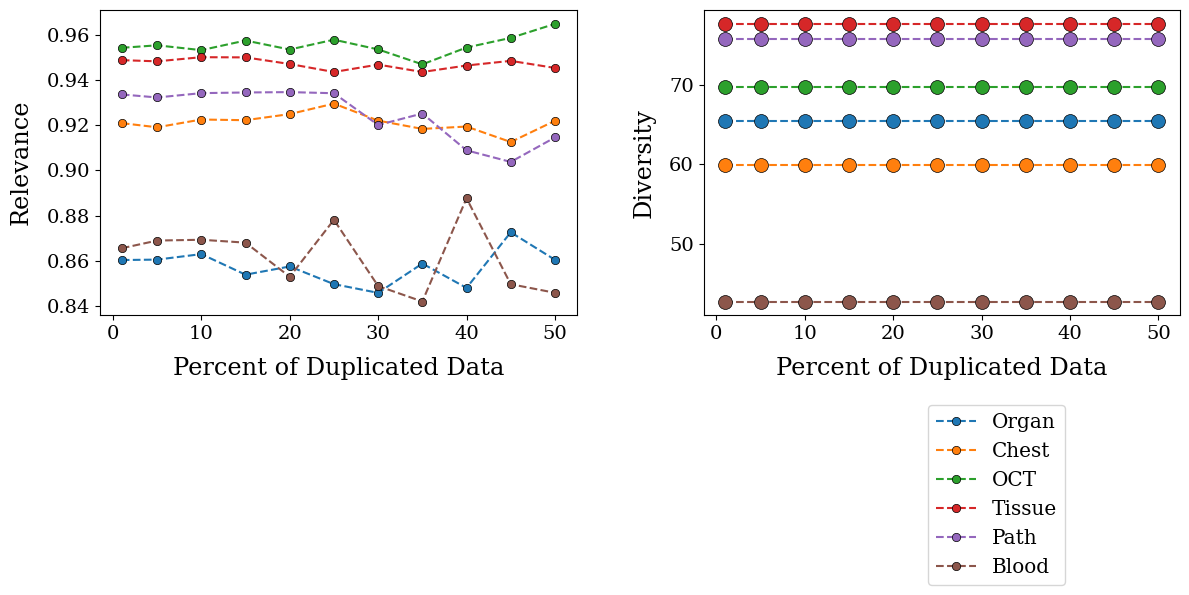

In [137]:
K = 0

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for i, (dataset, meas) in enumerate(omega_measurements[list(omega_measurements.keys())[K]].items()):
    ax[0].plot(
        meas.keys(),
        [v['overlap'] for v in meas.values()],
        label=dataset,
        # c=viridis[i],
        # marker=get_marker(seller),
        marker='o',
        markeredgecolor='k',
        markeredgewidth=0.5,
        zorder=2 if seller == buyer else 1,
        ls = '--',
        # **plot_kwargs,
    )
    ax[1].plot(
        meas.keys(),
        [v['volume'] for v in meas.values()],
        # label=dataset,
        # c=seller_color[seller],
        # marker=get_marker(seller),
        # c=viridis[i],
        marker='o',
        markersize=10, 
        markeredgecolor='k',
        markeredgewidth=0.5,
        zorder=2 if seller == buyer else 1,
        ls = '--',
        # **plot_kwargs,
    )
ax[0].set_xlabel("Percent of Duplicated Data", labelpad=10, fontsize='xx-large')
ax[0].set_ylabel("Relevance", labelpad=10, fontsize='xx-large')
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_xlabel("Percent of Duplicated Data", labelpad=10, fontsize='xx-large')
ax[1].set_ylabel("Diversity", labelpad=10, fontsize='xx-large')
ax[1].tick_params(axis='both', which='major', labelsize=14)
fig.legend(bbox_to_anchor=(0.9, 0.0), fontsize='x-large',  fancybox=True)
fig.tight_layout(w_pad=4)
# plt.savefig(fig_dir / f"mnist-vary-comp.eps", bbox_inches='tight')
plt.show()

In [138]:
agg_omega_measurements = {}
# Aggregate by averaging measurments over MedMNIST datasets
for k, v in omega_measurments.items():
    agg_measurements = defaultdict(list)
    for dataset, meas in v.items():
        repeats = meas.keys()
        agg_measurements['relevance'].append(list(v["overlap"] for v in meas.values()))
        agg_measurements['diversity'].append(list(v["volume"] for v in meas.values()))
    agg_omega_measurements[k] = {
        'relevance': np.array(agg_measurements['relevance']).mean(0),
        'diversity': np.array(agg_measurements['diversity']).mean(0),
    }

In [139]:
viridis = plt.cm.viridis(np.linspace(0, 1, 7))

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

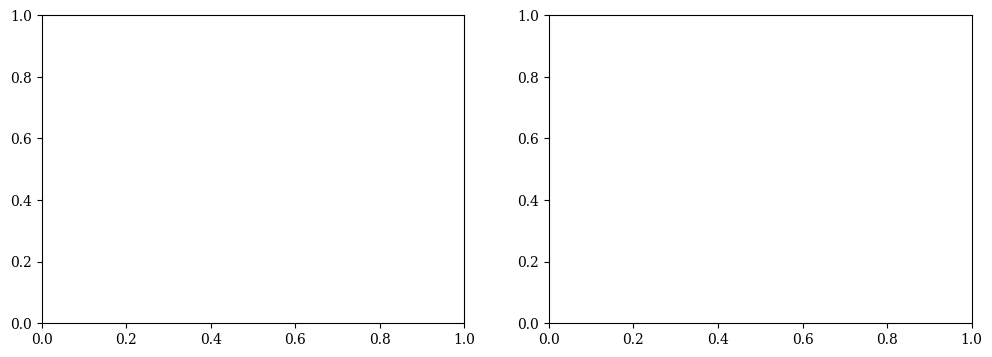

In [140]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for i, (omega, agg_meas) in enumerate(agg_omega_measurements.items()):
    ax[0].plot(
        num_repeats,
        agg_meas['relevance'],
        label=omega,
        c=viridis[i],
        # marker=get_marker(seller),
        marker='o',
        markeredgecolor='k',
        markeredgewidth=0.5,
        zorder=2 if seller == buyer else 1,
        ls = '--',
        # **plot_kwargs,
    )
    ax[1].plot(
        num_repeats,
        agg_meas['diversity'],
        # c=seller_color[seller],
        # marker=get_marker(seller),
        c=viridis[i],
        marker='o',
        markersize=10, 
        markeredgecolor='k',
        markeredgewidth=0.5,
        zorder=2 if seller == buyer else 1,
        ls = '--',
        # **plot_kwargs,
    )
ax[0].set_xlabel("Percent of Duplicated Data", labelpad=10, fontsize='xx-large')
ax[0].set_ylabel("Relevance", labelpad=10, fontsize='xx-large')
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_xlabel("Percent of Duplicated Data", labelpad=10, fontsize='xx-large')
ax[1].set_ylabel("Diversity", labelpad=10, fontsize='xx-large')
ax[1].tick_params(axis='both', which='major', labelsize=14)
fig.legend(title=r'$\omega$', title_fontsize='x-large', 
           bbox_to_anchor=(0.9, 0.0), fontsize='x-large',  fancybox=True)
fig.tight_layout(w_pad=4)
# plt.savefig(fig_dir / f"mnist-vary-comp.eps", bbox_inches='tight')
plt.show()